# Crime data of the city of Cambridge from 2009-2016. Includes crime types, report time, and location.

In [1]:
# importing important libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mlxtend.preprocessing as preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, chi2
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from apyori import apriori
from gsppy.gsp import GSP
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import col
from pyspark import SparkConf, SparkContext
from pyspark.mllib.fpm import FPGrowth
import geopandas as gpd
import leafmap.foliumap as leafmap
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [2]:
# printing the data in our data set
df = pd.read_csv(r"C:\Users\tinot\OneDrive\Documents\My Python Repository\Pandas\Cambridge Crime Data 2009-2016.csv")

# Data Cleaning and Overview

In [3]:
# viewing column names
df.columns

Index(['File Number', 'Date of Report', 'Crime Date Time', 'Crime',
       'Reporting Area', 'Neighborhood', 'Location'],
      dtype='object')

In [4]:
# Summary of the object's metadata and column information(total_rows, data_types)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56014 entries, 0 to 56013
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   File Number      56014 non-null  object 
 1   Date of Report   56014 non-null  object 
 2   Crime Date Time  56014 non-null  object 
 3   Crime            56014 non-null  object 
 4   Reporting Area   56012 non-null  float64
 5   Neighborhood     56012 non-null  object 
 6   Location         55931 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.0+ MB


In [5]:
# Descpritive statistics of the numerical columns in our data object
print(df.describe())

       Reporting Area
count    56012.000000
mean       619.753874
std        339.526023
min        101.000000
25%        403.000000
50%        602.000000
75%        910.000000
max       1304.000000


In [6]:
# Counting the number of missing values in each column to determine our next step
df.isna().sum()

File Number         0
Date of Report      0
Crime Date Time     0
Crime               0
Reporting Area      2
Neighborhood        2
Location           83
dtype: int64

In [7]:
# Drop missing values, we have few missing values, so this won't affect our dataset that much
df.dropna(inplace=True)
df.isna().sum()

File Number        0
Date of Report     0
Crime Date Time    0
Crime              0
Reporting Area     0
Neighborhood       0
Location           0
dtype: int64

In [8]:
# check for duplicated rows
df.duplicated().sum()

2

In [9]:
# delete rows of duplicated data
df = df.drop_duplicates()
df

,File Number,Date of Report,Crime Date Time,Crime,Reporting Area,Neighborhood,Location
0,2009-00002,01/01/2009 12:39:00 AM,1/1/09 0:39,Simple Assault,504.0,Cambridgeport,"400 Massachusetts Avenue, Cambridge, MA"
1,2009-00003,01/01/2009 01:34:00 AM,1/1/09 1:34,Simple Assault,610.0,Mid-Cambridge,"200 HAMPSHIRE STREET, Cambridge, MA"
2,2009-00004,01/01/2009 01:43:00 AM,01/01/2009 02:20 - 02:35,Aggravated Assault,708.0,Riverside,"DUNSTER STREET & MOUNT AUBURN STREET, Cambridg..."
3,2009-00005,01/01/2009 02:27:00 AM,01/01/2009 02:20 - 02:45,Simple Assault,105.0,East Cambridge,"100 SCIARAPPA STREET, Cambridge, MA"
4,2009-00006,01/01/2009 02:34:00 AM,01/01/2009 02:15 - 02:35,Disorderly,708.0,Riverside,"1200 Massachusetts Avenue, Cambridge, MA"
...,...,...,...,...,...,...,...
56009,2016-07187,09/30/2016 04:05:00 PM,09/28/2016 17:00 - 18:00,Larceny from Residence,510.0,Cambridgeport,"0 FAIRMONT AVE, Cambridge, MA"
56010,2016-07189,09/30/2016 05:38:00 PM,09/30/2016 16:30 - 17:38,Hit and Run,1105.0,North Cambridge,"2000 MASSACHUSETTS AVE, Cambridge, MA"
56011,2016-07192,09/30/2016 06:52:00 PM,09/16/2016 18:52 - 09/30/2016 18:52,Harassment,702.0,Riverside,"0 Soden St, Cambridge, MA"
56012,2016-07194,09/30/2016 07:52:00 PM,09/30/2016 19:51,Hit and Run,1002.0,West Cambridge,"University Rd & Mount Auburn St, Cambridge, MA"


In [10]:
# Clean Crime Date time column to remove - and spaces
df['Crime Date Time'] = df['Crime Date Time'].apply(lambda x: x.split(' - ')[0])

In [11]:
df

,File Number,Date of Report,Crime Date Time,Crime,Reporting Area,Neighborhood,Location
0,2009-00002,01/01/2009 12:39:00 AM,1/1/09 0:39,Simple Assault,504.0,Cambridgeport,"400 Massachusetts Avenue, Cambridge, MA"
1,2009-00003,01/01/2009 01:34:00 AM,1/1/09 1:34,Simple Assault,610.0,Mid-Cambridge,"200 HAMPSHIRE STREET, Cambridge, MA"
2,2009-00004,01/01/2009 01:43:00 AM,01/01/2009 02:20,Aggravated Assault,708.0,Riverside,"DUNSTER STREET & MOUNT AUBURN STREET, Cambridg..."
3,2009-00005,01/01/2009 02:27:00 AM,01/01/2009 02:20,Simple Assault,105.0,East Cambridge,"100 SCIARAPPA STREET, Cambridge, MA"
4,2009-00006,01/01/2009 02:34:00 AM,01/01/2009 02:15,Disorderly,708.0,Riverside,"1200 Massachusetts Avenue, Cambridge, MA"
...,...,...,...,...,...,...,...
56009,2016-07187,09/30/2016 04:05:00 PM,09/28/2016 17:00,Larceny from Residence,510.0,Cambridgeport,"0 FAIRMONT AVE, Cambridge, MA"
56010,2016-07189,09/30/2016 05:38:00 PM,09/30/2016 16:30,Hit and Run,1105.0,North Cambridge,"2000 MASSACHUSETTS AVE, Cambridge, MA"
56011,2016-07192,09/30/2016 06:52:00 PM,09/16/2016 18:52,Harassment,702.0,Riverside,"0 Soden St, Cambridge, MA"
56012,2016-07194,09/30/2016 07:52:00 PM,09/30/2016 19:51,Hit and Run,1002.0,West Cambridge,"University Rd & Mount Auburn St, Cambridge, MA"


# Transforming Categorical Variables using Label Encoding

In [12]:
# label encoding
le = LabelEncoder()
df['Crime Encoded'] = le.fit_transform(df['Crime'])
df['Neighborhood Encoded'] = le.fit_transform(df['Neighborhood'])

In [13]:
# the year crime took place
df['Crime Date Time'] = pd.to_datetime(df['Crime Date Time'])
df['Crime Year'] = df['Crime Date Time'].dt.year # Extract the year
df['Crime Year'] = df['Crime Year'].astype(int)
#df['Crime Year Encoded'] = le.fit_transform(df['Crime Year']) # Encode the time


In [14]:
# Extracting crime month
df['Crime Date Time'] = pd.to_datetime(df['Crime Date Time'])
df['Crime Month'] = df['Crime Date Time'].dt.month

In [15]:
# Extracting crime day
df['Crime Date Time'] = pd.to_datetime(df['Crime Date Time'])
df['Crime Day of Week'] = df['Crime Date Time'].dt.day


In [16]:
# the time crime took place
df['Crime Date Time'] = pd.to_datetime(df['Crime Date Time'])
# Extract the hour from the datetime
df['Crime Time'] = df['Crime Date Time'].dt.hour
# Group by Crime Time and apply 'ngroup' function
df['Crime Time'] = df.groupby('Crime Time')['Crime Time'].ngroup()
df['Crime Time'] = le.fit_transform(df['Crime Time']) # Encode the time


# Dimensionality Reduction

In [17]:
# Dimensionality Reduction of dimensions that are not informative for my specific analysis and can be excluded.
# Remove the columns 'File Number', 'Date of Report', and 'Crime Date Time'
df = df.drop(['File Number', 'Date of Report', 'Crime Date Time', 'Reporting Area'], axis=1)

# Correlation Analysis

In [18]:
# Subset the DataFrame to include only the numerical columns
numerical_data = df[['Crime Encoded', 'Crime Time', 'Neighborhood Encoded']]
# Compute the correlation matrix
correlation_matrix = numerical_data.corr()
# Print the correlation matrix
print(correlation_matrix)

                      Crime Encoded  Crime Time  Neighborhood Encoded
Crime Encoded              1.000000    0.016599             -0.034873
Crime Time                 0.016599    1.000000             -0.005754
Neighborhood Encoded      -0.034873   -0.005754              1.000000


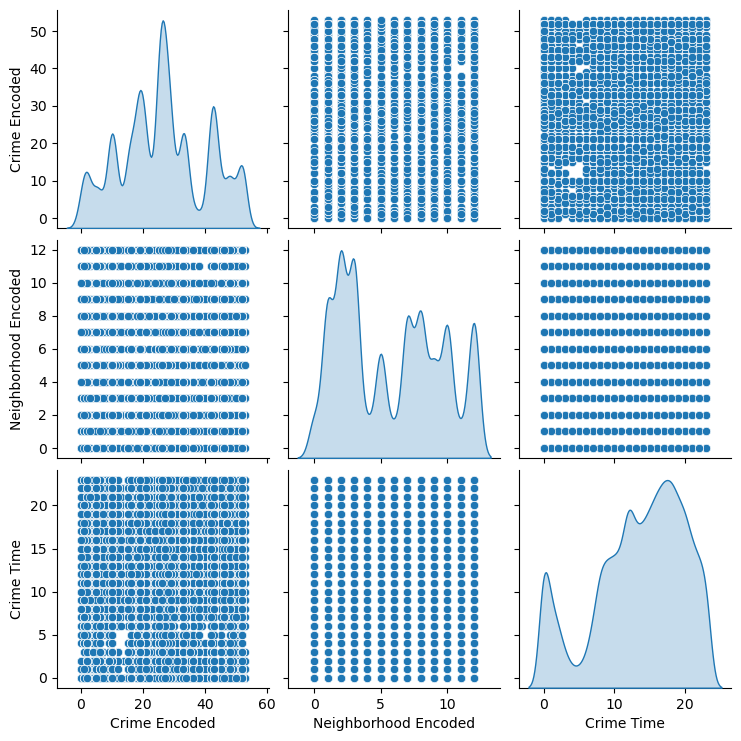

In [19]:
sns.pairplot(df[['Crime Encoded', 'Neighborhood Encoded', 'Crime Time']], diag_kind='kde')
plt.show()

# K-Means Clustering 

In [20]:
# Determing the number of optimum number of clusters using the Elbow method
def optimise_k_means(data, max_k):
    means = []
    inertias = []
    
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)

    # Generate the elbow plot
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means, inertias, 'o-')
    plt.title('Elbow Method for Choosing the Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares(Inertia)')
    plt.grid(True)
    plt.show()


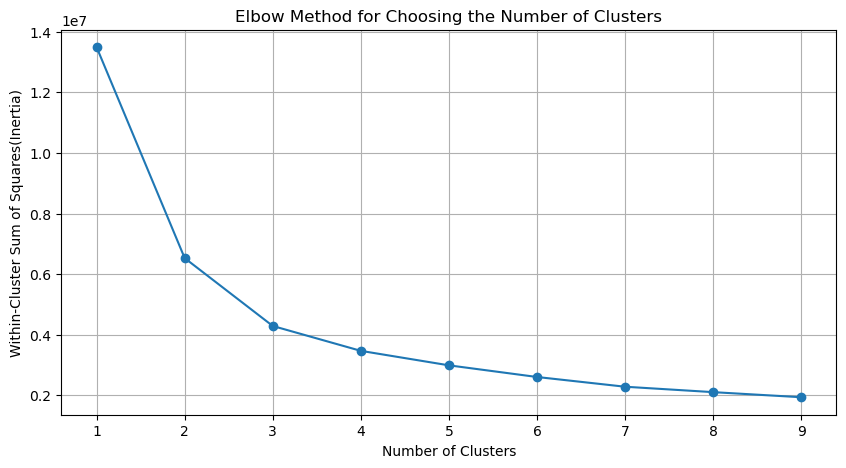

In [21]:
optimise_k_means(df[['Crime Encoded', 'Crime Time', 'Neighborhood Encoded']], 10)

In [22]:
# In the plot above, we can see that inertia(sum of the squared distances to the nearest cluster center) decreases as we increase the number of clusters
# We can see that there is a big change in inertia and slope from cluster 2 onwards

# Creating Multiple Clusters

In [23]:
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df[['Crime Encoded', 'Crime Time', 'Neighborhood Encoded']])
    df[f'KMeans_{k}'] = kmeans.labels_

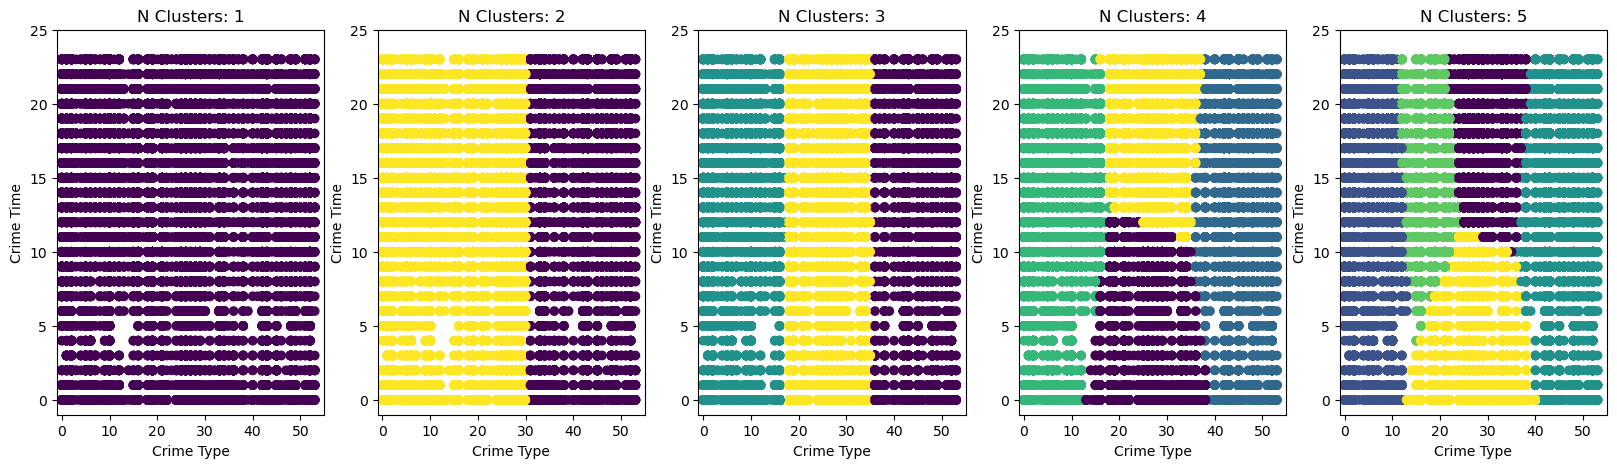

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))

for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=df['Crime Encoded'], y=df['Crime Time'], c=df[f'KMeans_{i}'])
    ax.set_xlim(-1, 55)
    ax.set_ylim(-1, 25)
    ax.set_xlabel('Crime Type')
    ax.set_ylabel('Crime Time')
    ax.set_title(f'N Clusters: {i}')

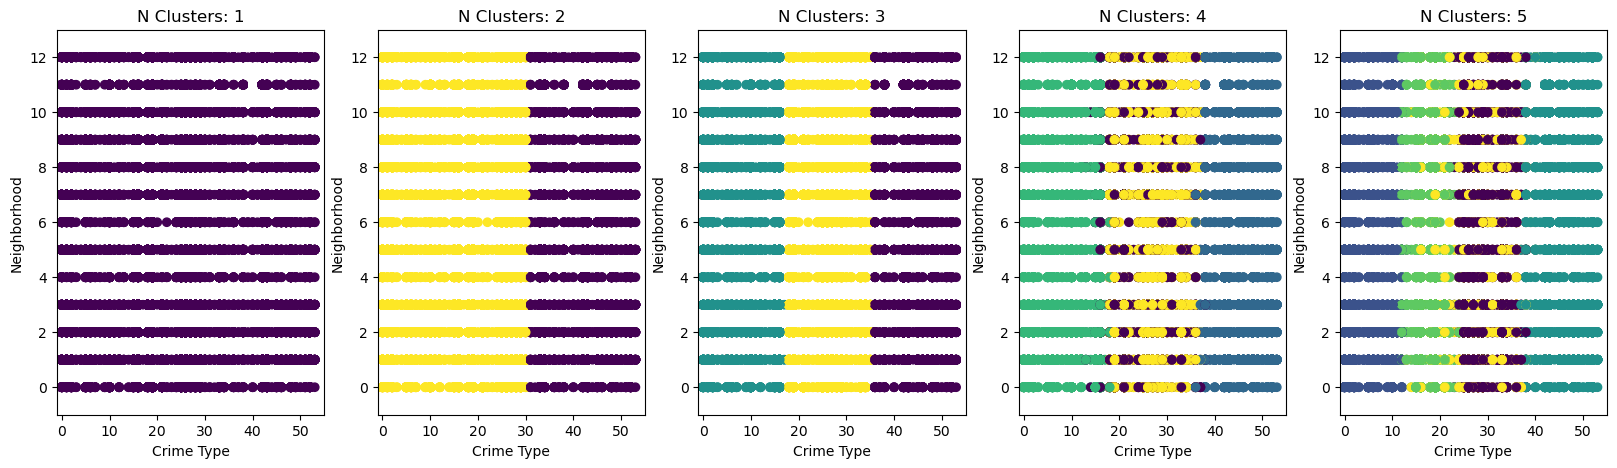

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))

for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=df['Crime Encoded'], y=df['Neighborhood Encoded'], c=df[f'KMeans_{i}'])
    ax.set_xlim(-1, 55)
    ax.set_ylim(-1, 13)
    ax.set_xlabel('Crime Type')
    ax.set_ylabel('Neighborhood')
    ax.set_title(f'N Clusters: {i}')

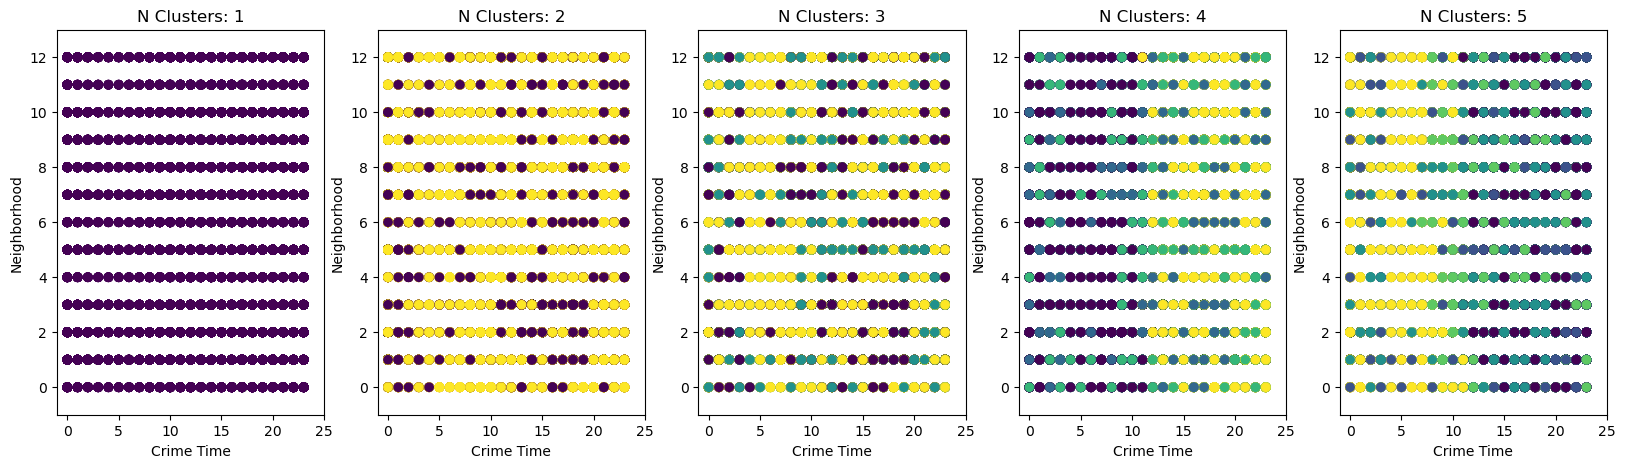

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))

for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=df['Crime Time'], y=df['Neighborhood Encoded'], c=df[f'KMeans_{i}'])
    ax.set_xlim(-1, 25)
    ax.set_ylim(-1, 13)
    ax.set_xlabel('Crime Time')
    ax.set_ylabel('Neighborhood')
    ax.set_title(f'N Clusters: {i}')

In [27]:
# Choosing A single 

In [28]:
# Applying K-Means Clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['Crime Encoded', 'Crime Time', 'Neighborhood Encoded']])

KMeans(n_clusters=4)

In [29]:
df['kmeans_3'] = kmeans.labels_

Text(0.5, 1.0, 'Crime Type vs Crime')

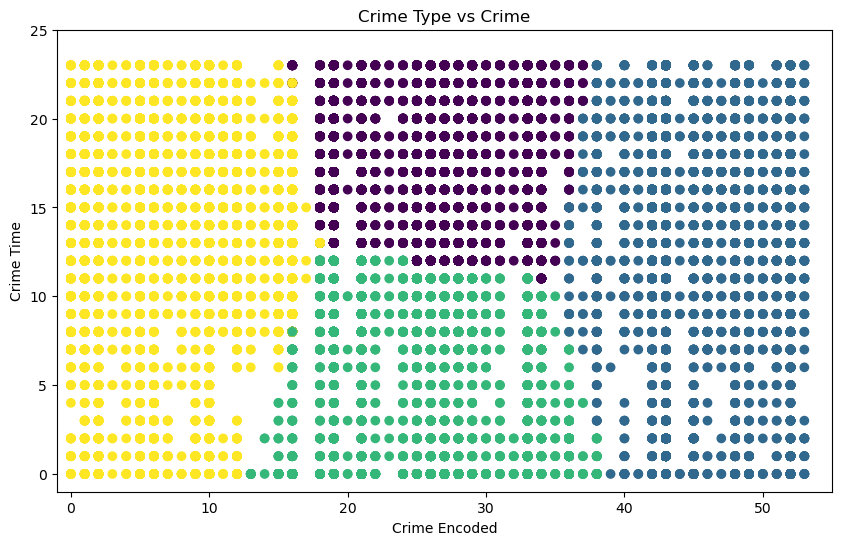

In [30]:
plt.figure(figsize=(10,6))
plt.scatter(x=df['Crime Encoded'], y=df['Crime Time'], c=df['kmeans_3'])
plt.xlabel('Crime Encoded')
plt.ylabel('Crime Time')
plt.xlim(-1, 55)
plt.ylim(-1, 25)
plt.title('Crime Type vs Crime')

# Apriori Algorithm

In [31]:
#Crime Type and Neighborhood:
#Investigate associations between crime types and specific neighborhoods. 
#This can provide insights into crime patterns within different neighborhoods and potentially uncover
#any localized trends.
itemset = list(df[['Crime Encoded', 'Neighborhood Encoded']].values)

# Apply the apriori algorithm to the itemset
association_rules = apriori(itemset, min_support=0.01, min_confidence=0.2)
association_results = list(association_rules)

# Calculate the confidence and for each rule
for item in association_results:

    #First index of the inner list
    # Contains base item and add item 
    pair = item[0]
    items = [x for x in pair]
    print('Rule:' + str(items[0]) + ' -> ' + str(items[1]))

    #Second index of the inner list
    print('Support: ' + str(item[1]))

    #Third index of the inner list located at 0th of the third index of the inner list
    print('Confidence: ' + str(item[2][0][2]))
    print('Lift: ' + str(item[2][0][3]))
    print('===================================================')



Rule:42 -> 3
Support: 0.020508877644071735
Confidence: 0.4114060258249641
Lift: 2.9688651362984215
Rule:3 -> 52
Support: 0.010013052729450892
Confidence: 0.2177293934681182
Lift: 1.5712195856117994


In [32]:
#Crime Type and Crime Time:
#Explore associations between crime types and the times at which they were reported. 
#This can reveal any time-related patterns or associations with specific crime types.
itemset = list(df[['Crime Encoded', 'Crime Time']].values)

# Apply the apriori algorithm to the itemset
association_rules = apriori(itemset, min_support=0.001, min_confidence=0.2)
association_results = list(association_rules)

# Calculate the confidence and for each rule
for item in association_results:

    #First index of the inner list
    # Contains base item and add item 
    pair = item[0]
    items = [x for x in pair]
    print('Rule:' + str(items[0]) + ' -> ' + str(items[1]))

    #Second index of the inner list
    print('Support: ' + str(item[1]))

    #Third index of the inner list located at 0th of the third index of the inner list
    print('Confidence: ' + str(item[2][0][2]))
    print('Lift: ' + str(item[2][0][3]))
    print('===================================================')

Rule:17 -> 47
Support: 0.0012695120424839523
Confidence: 0.27413127413127414
Lift: 4.0612820578383495


In [56]:
#Crime Type and Crime Time:
#Explore associations between crime types and the times at which they were reported. 
#This can reveal any time-related patterns or associations with specific crime types.
itemset = list(df[['Crime Encoded', 'Neighborhood Encoded', 'Crime Time']].values)

# Apply the apriori algorithm to the itemset
association_rules = apriori(itemset, min_support=0.01, min_confidence=0.25)
association_results = list(association_rules)

# Calculate the confidence and for each rule
for item in association_results:

    #First index of the inner list
    # Contains base item and add item 
    pair = item[0]
    items = [x for x in pair]
    print('Rule:' + str(items[0]) + ' -> ' + str(items[1]))

    #Second index of the inner list
    print('Support: ' + str(item[1]))

    #Third index of the inner list located at 0th of the third index of the inner list
    print('Confidence: ' + str(item[2][0][2]))
    print('Lift: ' + str(item[2][0][3]))
    print('===================================================')


Rule:42 -> 3
Support: 0.020651921254492462
Confidence: 0.4142754662840746
Lift: 2.78375393522401
Rule:27 -> 12
Support: 0.010263379047687163
Confidence: 0.25241864555848725
Lift: 1.5037300372975624


In [48]:
association_results

[RelationRecord(items=frozenset({42, 3}), support=0.020651921254492462, ordered_statistics=[OrderedStatistic(items_base=frozenset({42}), items_add=frozenset({3}), confidence=0.4142754662840746, lift=2.78375393522401)]),
 RelationRecord(items=frozenset({27, 12}), support=0.010263379047687163, ordered_statistics=[OrderedStatistic(items_base=frozenset({27}), items_add=frozenset({12}), confidence=0.25241864555848725, lift=1.5037300372975624)])]

# Geospatial Analysis

In [24]:
# Now we use the Nominatim Geocoder from GeoPy. Nominatim geocoder is based on OpenStreetMap data.
from tqdm.notebook import tqdm

tqdm.pandas()

locator = Nominatim(user_agent='spatialthoughts', timeout=10)
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

address_df_pd = address_df.copy()
address_df_pd['location'] = address_df_pd['Full_Address'].progress_apply(geocode)
address_df_pd

NameError: name 'address_df' is not defined

In [ ]:
address_df_pd['latitude'] = address_df_pd['location'].apply(lambda loc: loc.latitude if loc else None)
address_df_pd['longitude'] = address_df_pd['location'].apply(lambda loc: loc.longitude if loc else None)
address_df_pd

In [34]:
#importing our geocoded addresses
geocoded_address = pd.read_csv(r"C:\Users\tinot\OneDrive\Documents\My Python Repository\Pandas\Addresses_Geocoded.csv")
geocoded_address = geocoded_address[['Address', 'Latitude', 'Longitude']]
geocoded_address

,Address,Latitude,Longitude
0,"400 Massachusetts Avenue, Cambridge, MA",42.363310,-71.100180
1,"200 HAMPSHIRE STREET, Cambridge, MA",42.373015,-71.100164
2,"DUNSTER STREET & MOUNT AUBURN STREET, Cambridg...",42.371930,-71.119530
3,"100 SCIARAPPA STREET, Cambridge, MA",42.368946,-71.081888
4,"1200 Massachusetts Avenue, Cambridge, MA",42.371663,-71.115059
...,...,...,...
55926,"0 FAIRMONT AVE, Cambridge, MA",42.361949,-71.112358
55927,"2000 MASSACHUSETTS AVE, Cambridge, MA",42.390347,-71.121412
55928,"0 Soden St, Cambridge, MA",42.365348,-71.108332
55929,"University Rd & Mount Auburn St, Cambridge, MA",42.373647,-71.123722


In [35]:
#We create a GeoDataFrame from the latitude and longitude columns.
geometry = gpd.points_from_xy(geocoded_address.Longitude, df.Latitude)
geocoded_address = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=geometry)

AttributeError: 'DataFrame' object has no attribute 'Latitude'

In [ ]:
# Visualize the geocoded addresses on a map.

# Frequency Analysis

In [38]:
df['Crime'].value_counts()

Crime
Larceny from MV           4826
Hit and Run               4652
Domestic Dispute          3899
Mal. Dest. Property       3666
Simple Assault            3292
Larceny from Building     2856
Shoplifting               2788
Larceny of Bicycle        2744
Housebreak                2668
Forgery                   2579
Warrant Arrest            2572
Larceny from Person       2274
Larceny from Residence    1739
Aggravated Assault        1726
Threats                   1633
Auto Theft                1101
Missing Person             949
Flim Flam                  936
Harassment                 812
Street Robbery             759
Drugs                      673
Admin Error                659
Accident                   626
Commercial Break           584
Phone Calls                450
OUI                        387
Suspicious Package         381
Violation of R.O.          377
Trespassing                359
Disorderly                 306
Larceny (Misc)             268
Taxi Violation             259
La

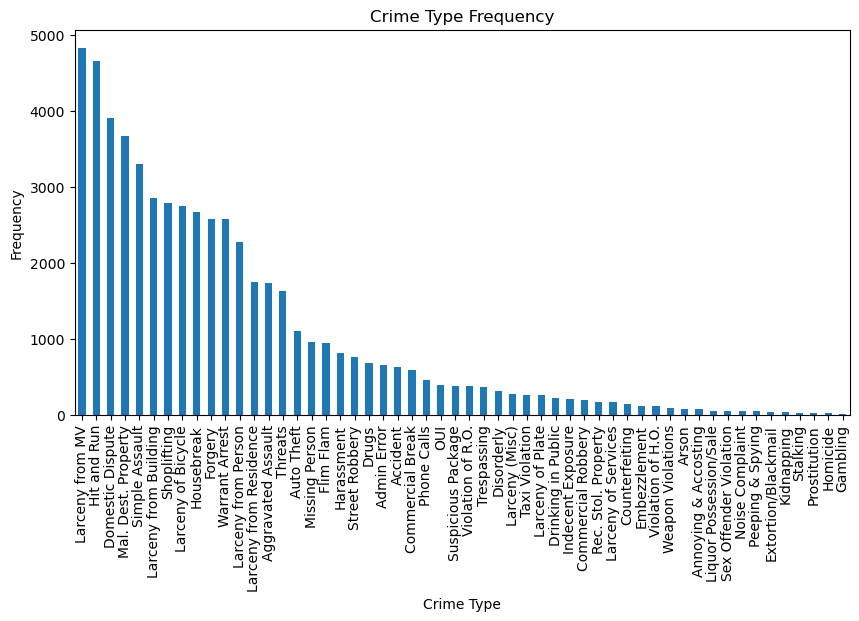

In [39]:
plt.figure(figsize=(10, 5))
df['Crime'].value_counts().plot(kind='bar')
plt.xlabel('Crime Type')
plt.ylabel('Frequency')
plt.title('Crime Type Frequency')
plt.show()

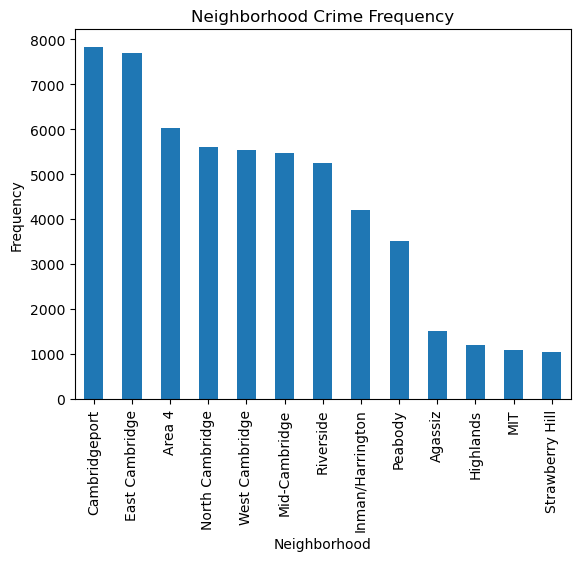

In [40]:
df['Neighborhood'].value_counts().plot(kind='bar')
plt.xlabel('Neighborhood')
plt.ylabel('Frequency')
plt.title('Neighborhood Crime Frequency')
plt.show()

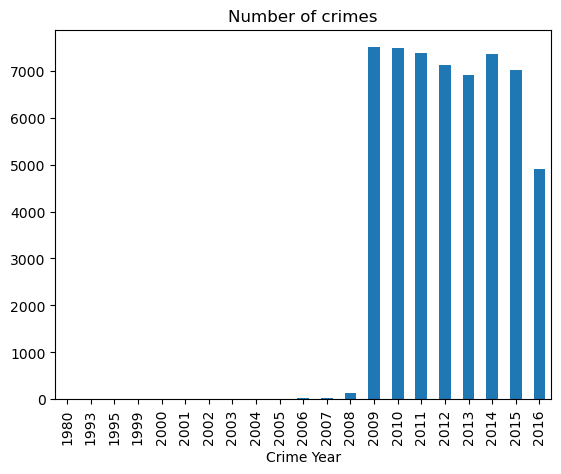

In [41]:
# In which year were the most crimes committed?
df.groupby('Crime Year').count()['Crime'].plot(kind='bar');
plt.title('Number of crimes');

Crime Day of Week
1     2359
16    1906
20    1897
13    1893
15    1891
21    1888
23    1880
18    1868
19    1853
12    1852
10    1844
17    1840
14    1833
22    1823
11    1821
9     1819
25    1816
26    1794
3     1781
7     1774
28    1773
6     1771
8     1765
5     1761
24    1757
27    1753
2     1745
30    1731
4     1722
29    1684
31    1033
Name: Crime, dtype: int64

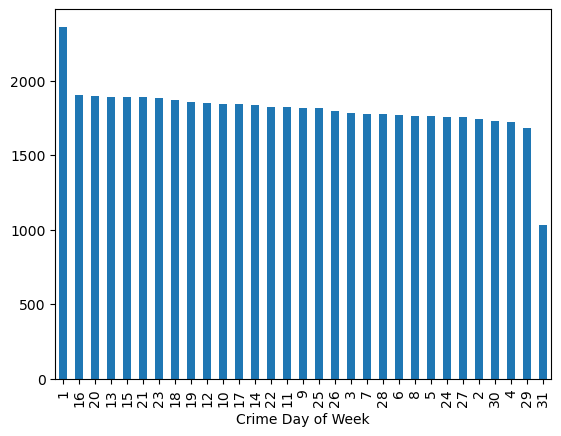

In [42]:
# Are there more crimes committed on specific days?

display(df.groupby('Crime Day of Week').count()['Crime'].sort_values(ascending=False));

df.groupby('Crime Day of Week').count()['Crime'].sort_values(ascending=False).plot(kind='bar');

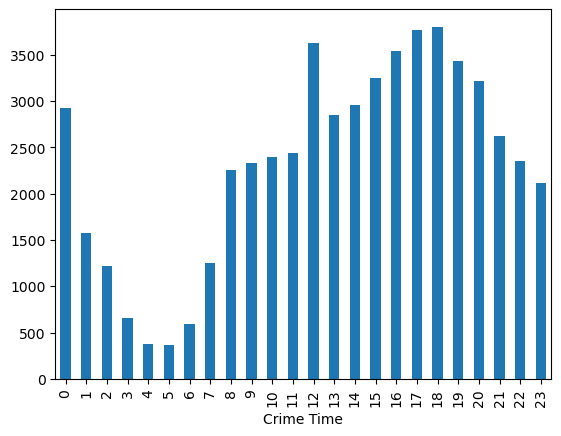

In [43]:
# Are there more crimes during specific hours?
df.groupby('Crime Time').count()['Crime'].plot(kind='bar');

In [ ]:
# In which months were the number of crimes below average? 
# In which months on average did the most crimes occur?

In [46]:
# if the value is less than the average crime per month, highlight the value in blue

avg_crime = df.groupby(['Crime Year', 'Crime Month']).count()['Crime'].mean()
print("The average number of crimes is " + str(avg_crime))

year_and_month = df.groupby(['Crime Month', 'Crime Year']).count()['Crime'].unstack()

def style_negative(v, props=''):
    return props if v < avg_crime else None
s2 = year_and_month.style.applymap(style_negative, props='color:blue;')\
              .applymap(lambda v: 'opacity: 20%;' if (v < 0.3) and (v > -0.3) else None)
s2

The average number of crimes is 358.5064102564103


Crime Year,1980,1993,1995,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Crime Month,,,,,,,,,,,,,,,,,,,,,
1,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,7.000000,3.000000,3.000000,10.000000,9.000000,592.000000,525.000000,509.000000,553.000000,518.000000,499.000000,520.000000,489.000000
2,nan,nan,nan,nan,nan,1.000000,nan,nan,1.000000,nan,2.000000,2.000000,3.000000,552.000000,480.000000,510.000000,517.000000,470.000000,455.000000,524.000000,466.000000
3,nan,nan,nan,nan,1.000000,1.000000,nan,nan,1.000000,2.000000,nan,2.000000,7.000000,589.000000,545.000000,583.000000,611.000000,494.000000,522.000000,543.000000,490.000000
4,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,2.000000,2.000000,1.000000,6.000000,584.000000,605.000000,575.000000,549.000000,545.000000,572.000000,555.000000,559.000000
5,nan,nan,nan,nan,nan,3.000000,1.000000,nan,nan,nan,1.000000,3.000000,5.000000,661.000000,661.000000,623.000000,596.000000,578.000000,644.000000,645.000000,576.000000
6,nan,nan,nan,nan,nan,2.000000,nan,nan,nan,nan,2.000000,2.000000,8.000000,636.000000,699.000000,688.000000,639.000000,605.000000,678.000000,648.000000,643.000000
7,nan,nan,nan,nan,nan,3.000000,nan,nan,nan,nan,1.000000,nan,3.000000,706.000000,718.000000,739.000000,688.000000,720.000000,656.000000,702.000000,570.000000
8,nan,nan,nan,nan,nan,1.000000,1.000000,nan,nan,nan,nan,1.000000,7.000000,727.000000,722.000000,644.000000,698.000000,707.000000,749.000000,617.000000,593.000000
9,nan,nan,nan,nan,nan,1.000000,nan,nan,4.000000,nan,nan,nan,10.000000,644.000000,716.000000,629.000000,614.000000,636.000000,707.000000,566.000000,518.000000


In [47]:
# Use apply to highlight the maximum in a column in darkgreen

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
s2.apply(highlight_max, props='color:white;background-color:darkgreen', axis=0)

Crime Year,1980,1993,1995,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Crime Month,,,,,,,,,,,,,,,,,,,,,
1,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,7.000000,3.000000,3.000000,10.000000,9.000000,592.000000,525.000000,509.000000,553.000000,518.000000,499.000000,520.000000,489.000000
2,nan,nan,nan,nan,nan,1.000000,nan,nan,1.000000,nan,2.000000,2.000000,3.000000,552.000000,480.000000,510.000000,517.000000,470.000000,455.000000,524.000000,466.000000
3,nan,nan,nan,nan,1.000000,1.000000,nan,nan,1.000000,2.000000,nan,2.000000,7.000000,589.000000,545.000000,583.000000,611.000000,494.000000,522.000000,543.000000,490.000000
4,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,2.000000,2.000000,1.000000,6.000000,584.000000,605.000000,575.000000,549.000000,545.000000,572.000000,555.000000,559.000000
5,nan,nan,nan,nan,nan,3.000000,1.000000,nan,nan,nan,1.000000,3.000000,5.000000,661.000000,661.000000,623.000000,596.000000,578.000000,644.000000,645.000000,576.000000
6,nan,nan,nan,nan,nan,2.000000,nan,nan,nan,nan,2.000000,2.000000,8.000000,636.000000,699.000000,688.000000,639.000000,605.000000,678.000000,648.000000,643.000000
7,nan,nan,nan,nan,nan,3.000000,nan,nan,nan,nan,1.000000,nan,3.000000,706.000000,718.000000,739.000000,688.000000,720.000000,656.000000,702.000000,570.000000
8,nan,nan,nan,nan,nan,1.000000,1.000000,nan,nan,nan,nan,1.000000,7.000000,727.000000,722.000000,644.000000,698.000000,707.000000,749.000000,617.000000,593.000000
9,nan,nan,nan,nan,nan,1.000000,nan,nan,4.000000,nan,nan,nan,10.000000,644.000000,716.000000,629.000000,614.000000,636.000000,707.000000,566.000000,518.000000


In [44]:
df

,Crime,Neighborhood,Location,Crime Encoded,Neighborhood Encoded,Crime Year,Crime Month,Crime Day of Week,Crime Time,KMeans_1,KMeans_2,KMeans_3,KMeans_4,KMeans_5,kmeans_3
0,Simple Assault,Cambridgeport,"400 Massachusetts Avenue, Cambridge, MA",43,2,2009,1,1,0,0,1,1,1,1,0
1,Simple Assault,Mid-Cambridge,"200 HAMPSHIRE STREET, Cambridge, MA",43,7,2009,1,1,1,0,1,1,1,1,0
2,Aggravated Assault,Riverside,"DUNSTER STREET & MOUNT AUBURN STREET, Cambridg...",2,10,2009,1,1,2,0,0,2,0,0,1
3,Simple Assault,East Cambridge,"100 SCIARAPPA STREET, Cambridge, MA",43,3,2009,1,1,2,0,1,1,1,1,0
4,Disorderly,Riverside,"1200 Massachusetts Avenue, Cambridge, MA",9,10,2009,1,1,2,0,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56009,Larceny from Residence,Cambridgeport,"0 FAIRMONT AVE, Cambridge, MA",28,2,2016,9,28,17,0,0,0,2,2,2
56010,Hit and Run,North Cambridge,"2000 MASSACHUSETTS AVE, Cambridge, MA",19,8,2016,9,30,16,0,0,0,2,4,2
56011,Harassment,Riverside,"0 Soden St, Cambridge, MA",18,10,2016,9,16,18,0,0,0,2,4,2
56012,Hit and Run,West Cambridge,"University Rd & Mount Auburn St, Cambridge, MA",19,12,2016,9,30,19,0,0,0,2,4,2


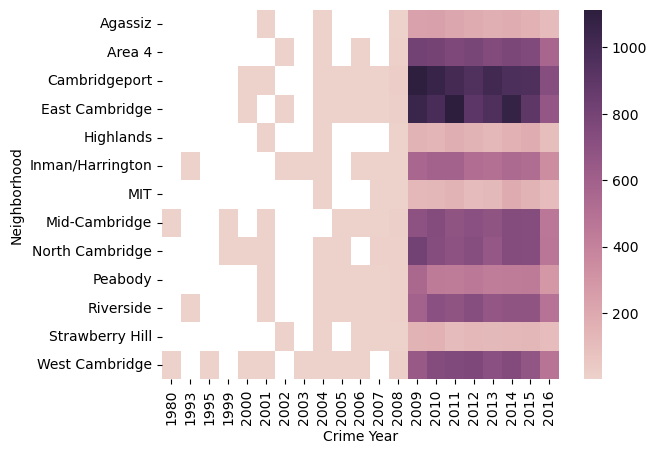

In [48]:
# Question 4 - In which Neighborhood were the most crimes committed every year? 
# Try and use everything you've learned in this video to answer this question.
# Feel free to use functions, tables, and other visuals.

district_and_year = df.groupby(['Neighborhood', 'Crime Year']).count()['Crime'].unstack()

sns.heatmap(district_and_year, cmap=sns.cubehelix_palette(as_cmap=True));

In [41]:
df

,File Number,Date of Report,Crime Date Time,Crime,Reporting Area,Neighborhood,Location,Crime Encoded,Neighborhood Encoded
0,2009-00002,1/1/2009 0:39,1/1/2009 0:39,Simple Assault,504.0,Cambridgeport,"400 Massachusetts Avenue, Cambridge, MA",43,2
1,2009-00003,1/1/2009 1:34,1/1/2009 1:34,Simple Assault,610.0,Mid-Cambridge,"200 HAMPSHIRE STREET, Cambridge, MA",43,7
2,2009-00004,1/1/2009 1:43,01/01/2009 02:20,Aggravated Assault,708.0,Riverside,"DUNSTER STREET & MOUNT AUBURN STREET, Cambridg...",2,10
3,2009-00005,1/1/2009 2:27,01/01/2009 02:20,Simple Assault,105.0,East Cambridge,"100 SCIARAPPA STREET, Cambridge, MA",43,3
4,2009-00006,1/1/2009 2:34,01/01/2009 02:15,Disorderly,708.0,Riverside,"1200 Massachusetts Avenue, Cambridge, MA",9,10
...,...,...,...,...,...,...,...,...,...
55777,2016-07187,9/30/2016 16:05,09/28/2016 17:00,Larceny from Residence,510.0,Cambridgeport,"0 FAIRMONT AVE, Cambridge, MA",28,2
55778,2016-07189,9/30/2016 17:38,09/30/2016 16:30,Hit and Run,1105.0,North Cambridge,"2000 MASSACHUSETTS AVE, Cambridge, MA",19,8
55779,2016-07192,9/30/2016 18:52,09/16/2016 18:52,Harassment,702.0,Riverside,"0 Soden St, Cambridge, MA",18,10
55780,2016-07194,9/30/2016 19:52,9/30/2016 19:51,Hit and Run,1002.0,West Cambridge,"University Rd & Mount Auburn St, Cambridge, MA",19,12


In [45]:
# Set option to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Display the entire dataset
print(df)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [38]:
subset = df.iloc[50000:51000]  # Extract the subset of rows from 100 to 150 (inclusive)
subset

,Crime,Neighborhood,Location,Crime Encoded,Neighborhood Encoded,Crime Year,Crime Month,Crime Day of Week,Crime Time,KMeans_1,KMeans_2,KMeans_3,KMeans_4,KMeans_5,kmeans_3
50070,Larceny of Bicycle,Agassiz,"0 KIRKLAND ST, Cambridge, MA",29,0,2015,11,12,8,0,1,2,0,4,2
50071,Larceny from Building,North Cambridge,"0 PORTER SQ, Cambridge, MA",25,8,2015,11,10,20,0,1,2,3,0,0
50072,Suspicious Package,West Cambridge,"0 ELIOT ST, Cambridge, MA",46,12,2015,11,12,11,0,0,0,1,2,1
50073,Larceny (Misc),Cambridgeport,"600 MASSACHUSETTS AVE, Cambridge, MA",24,2,2015,11,12,11,0,1,2,0,4,2
50074,Shoplifting,Riverside,"1300 MASSACHUSETTS AVE, Cambridge, MA",42,10,2015,11,12,12,0,0,0,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51069,Larceny from MV,Riverside,"0 JAY ST, Cambridge, MA",26,10,2016,1,6,19,0,1,2,3,0,0
51070,Hit and Run,Inman/Harrington,"CAMBRIDGE ST & WINDSOR ST, Cambridge, MA",19,5,2016,1,6,20,0,1,2,3,3,0
51071,Violation of R.O.,Cambridgeport,"400 MASSACHUSETTS AVE, Cambridge, MA",51,2,2016,1,7,8,0,0,0,1,2,1
51072,Harassment,East Cambridge,"100 CHARLES ST, Cambridge, MA",18,3,2015,3,15,12,0,1,2,0,3,2


In [44]:
unique_values = df[['Crime', 'Crime Encoded']].apply(pd.Series.unique)

# Display the unique values
print(unique_values)

                     Crime  Crime Encoded
0           Simple Assault             43
1       Aggravated Assault              2
2               Disorderly              9
3           Missing Person             34
4      Mal. Dest. Property             33
5              Shoplifting             42
6              Hit and Run             19
7              Trespassing             49
8          Larceny from MV             26
9           Larceny (Misc)             24
10              Housebreak             21
11   Larceny from Building             25
12        Commercial Break              6
13  Larceny from Residence             28
14     Larceny from Person             27
15          Street Robbery             45
16                 Forgery             16
17                     OUI             36
18        Domestic Dispute             10
19          Warrant Arrest             52
20              Auto Theft              5
21                Accident              0
22      Larceny of Bicycle        

In [45]:
unique_values = df[[ 'Neighborhood', 'Neighborhood Encoded']].apply(pd.Series.unique)

# Display the unique values
print(unique_values)

        Neighborhood  Neighborhood Encoded
0      Cambridgeport                     2
1      Mid-Cambridge                     7
2          Riverside                    10
3     East Cambridge                     3
4    North Cambridge                     8
5             Area 4                     1
6          Highlands                     4
7            Agassiz                     0
8     West Cambridge                    12
9   Inman/Harrington                     5
10           Peabody                     9
11               MIT                     6
12   Strawberry Hill                    11


In [1]:
import numpy as np
from sklearn.cluster import KMeans

In [2]:
# Define the data points
data_points = np.array([[2, 10], [2, 5], [8, 4], [5, 8], [7, 5], [6, 4], [1, 2], [4, 9]])

In [3]:
# Initialize the cluster centers
initial_centers = np.array([[2, 10], [5, 8], [1, 2]])

In [4]:
# Create a KMeans object and fit the data
kmeans = KMeans(n_clusters=3, init=initial_centers, random_state=0)
kmeans.fit(data_points)

C:\Users\tinot\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tinot\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tinot\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(init=array([[ 2, 10],
       [ 5,  8],
       [ 1,  2]]), n_clusters=3,
       random_state=0)

In [5]:
# Get the final cluster labels
cluster_labels = kmeans.labels_

In [6]:
# Print the final clusters
for i in range(3):
    cluster_points = data_points[cluster_labels == i]
    print(f"Cluster {i+1}:")
    print(cluster_points)
    print("-------------")

Cluster 1:
[[ 2 10]
 [ 5  8]
 [ 4  9]]
-------------
Cluster 2:
[[8 4]
 [7 5]
 [6 4]]
-------------
Cluster 3:
[[2 5]
 [1 2]]
-------------


In [7]:
import numpy as np
from sklearn.cluster import KMeans

# Define the data points
data = np.array([[2,10], [2,5], [8,4], [5,8], [7,5], [6,4], [1,2], [4,9]])

# Initialize the cluster centers
centers = np.array([[2,10], [5,8], [1,2]])

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, init=centers, n_init=1, max_iter=100, tol=1e-4, random_state=0)
kmeans.fit(data)

# Print out the final three clusters
for i in range(3):
    cluster_points = data[kmeans.labels_ == i]
    print(f"Cluster {i+1}: {cluster_points}")

Cluster 1: [[ 2 10]
 [ 5  8]
 [ 4  9]]
Cluster 2: [[8 4]
 [7 5]
 [6 4]]
Cluster 3: [[2 5]
 [1 2]]


C:\Users\tinot\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
